In [1]:
###################################################################################################
#
# PairIdentification.py
#
# Copyright (C) by Andreas Zoglauer & Harrison Costatino.
#
# Please see the file LICENSE in the main repository for the copyright-notice.
#
###################################################################################################



###################################################################################################

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np

#from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.pyplot as plt

import random

import signal
import sys
import time
import math
import csv
import os
import argparse
import logging
import yaml
from datetime import datetime
from functools import reduce


print("\nPair Identification")
print("============================\n")



# Step 1: Input parameters
###################################################################################################


# Default parameters

# Split between training and testing data
TestingTrainingSplit = 0.1

MaxEvents = 1000

# File names
FileName = "PairIdentification.p1.sim.gz"
GeometryName = "$(MEGALIB)/resource/examples/geomega/GRIPS/GRIPS.geo.setup"


# Set in stone later
TestingTrainingSplit = 0.8

OutputDirectory = "Results"


parser = argparse.ArgumentParser(description='Perform training and/or testing of the pair identification machine learning tools.')
parser.add_argument('-d', '--datatype', default='tm2', help='One of: tm1: toy modle #1, tm2: toy model #2, f: file')
parser.add_argument('-f', '--filename', default='PairIdentification.p1.sim.gz', help='File name used for training/testing')
parser.add_argument('-m', '--maxevents', default='100', help='Maximum number of events to use')
parser.add_argument('-s', '--testingtrainigsplit', default='0.1', help='Testing-training split')
parser.add_argument('-b', '--batchsize', default='16', help='Batch size')

# Command line arguments for build model, to remove dependency on .yaml
parser.add_argument('--model_type', default='gnn_segment_classifier', help='model_type')
parser.add_argument('--optimizer', default='Adam', help='optimizer')
parser.add_argument('--learning_rate', default='0.001', help='learning_rate')
parser.add_argument('--loss_func', default='BCELoss', help='loss_func')
parser.add_argument('--input_dim', default='3', help='input_dim')
parser.add_argument('--hidden_dim', default='64', help='hidden_dim')
parser.add_argument('--n_iters', default='100', help='n_iters')
# parser.add_argument('--hidden_activation', default='nn.Tanh', help='hidden_activation')


args = parser.parse_args()

DataType = args.datatype

if args.filename != "":
  FileName = args.filename

if int(args.maxevents) >= 10:
  MaxEvents = int(args.maxevents)

if int(args.batchsize) >= 0:
  BatchSize = int(args.batchsize)

if float(args.testingtrainigsplit) >= 0.05:
  TestingTrainingSplit = float(args.testingtrainigsplit)


if os.path.exists(OutputDirectory):
  Now = datetime.now()
  OutputDirectory += Now.strftime("_%Y%m%d_%H%M%S")

os.makedirs(OutputDirectory)



###################################################################################################
# Step 2: Global functions
###################################################################################################


# Take care of Ctrl-C
Interrupted = False
NInterrupts = 0
def signal_handler(signal, frame):
  global Interrupted
  Interrupted = True
  global NInterrupts
  NInterrupts += 1
  if NInterrupts >= 2:
    print("Aborting!")
    sys.exit(0)
  print("You pressed Ctrl+C - waiting for graceful abort, or press  Ctrl-C again, for quick exit.")
signal.signal(signal.SIGINT, signal_handler)


# Everything ROOT related can only be loaded here otherwise it interferes with the argparse
from EventData import EventData

# Load MEGAlib into ROOT so that it is usable
import ROOT as M
M.gSystem.Load("$(MEGALIB)/lib/libMEGAlib.so")
M.PyConfig.IgnoreCommandLineOptions = True



###################################################################################################
# Step 3: Create some training, test & verification data sets
###################################################################################################


# Read the simulation file data:
DataSets = []
NumberOfDataSets = 0

if DataType == "tm1":
  for e in range(0, MaxEvents):
    Data = EventData()
    Data.createFromToyModelRealismLevel1(e)
    DataSets.append(Data)
    
    NumberOfDataSets += 1
    if NumberOfDataSets > 0 and NumberOfDataSets % 1000 == 0:
      print("Data sets processed: {}".format(NumberOfDataSets))

elif DataType == "tm2":
  for e in range(0, MaxEvents):
    Data = EventData()
    Data.createFromToyModelRealismLevel2(e)
    DataSets.append(Data)
    
    NumberOfDataSets += 1
    if NumberOfDataSets > 0 and NumberOfDataSets % 1000 == 0:
      print("Data sets processed: {}".format(NumberOfDataSets))

elif DataType == "f":
  # Load geometry:
  Geometry = M.MDGeometryQuest()
  if Geometry.ScanSetupFile(M.MString(GeometryName)) == True:
    print("Geometry " + GeometryName + " loaded!")
  else:
    print("Unable to load geometry " + GeometryName + " - Aborting!")
    quit()


  Reader = M.MFileEventsSim(Geometry)
  if Reader.Open(M.MString(FileName)) == False:
    print("Unable to open file " + FileName + ". Aborting!")
    quit()


  print("\n\nStarted reading data sets")
  NumberOfDataSets = 0
  while NumberOfDataSets < MaxEvents:
    Event = Reader.GetNextEvent()
    if not Event:
      break

    if Event.GetNIAs() > 0:
      Data = EventData()
      if Data.parse(Event) == True:
        if Data.hasHitsOutside(XMin, XMax, YMin, YMax, ZMin, ZMax) == False:
          DataSets.append(Data)
          NumberOfDataSets += 1
          if NumberOfDataSets % 500 == 0:
            print("Data sets processed: {}".format(NumberOfDataSets))

else:
  print("Unknown data type \"{}\" Must be one of tm1, tm2, f".format(DataType))
  quit()

print("Info: Parsed {} events".format(NumberOfDataSets))

# Split the data sets in training and testing data sets

TestingTrainingSplit = 0.75


numEvents = len(DataSets)

numTraining = int(numEvents * TestingTrainingSplit)

TrainingDataSets = DataSets[:numTraining]
TestingDataSets = DataSets[numTraining:]



# For testing/validation split
# ValidationDataSets = TestingDataSets[:int(len(TestingDataSets)/2)]
# TestingDataSets = TestingDataSets[int(len(TestingDataSets)/2):]

print("###### Data Split ########")
print("Training/Testing Split: {}".format(TestingTrainingSplit))
print("Total Data: {}, Training Data: {},Testing Data: {}".format(numEvents, len(TrainingDataSets), len(TestingDataSets)))
print("##########################")


###################################################################################################
# Step 4: Vectorize data using preprocess.py
###################################################################################################

from preprocess import generate_incidence, connect_pos, vectorize_data
import torch
import torch.distributed as dist
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler

# Locals
from datasets import get_data_loaders
from trainers import get_trainer

train_Edge_Labels, train_Man_Ri, train_Man_Ro, train_XYZ, train_Type, train_Energy, train_GammaEnergy, train_True_Ri, train_True_Ro = vectorize_data(TrainingDataSets)
test_Edge_Labels, test_Man_Ri, test_Man_Ro, test_XYZ, test_Type, test_Energy, test_GammaEnergy, test_True_Ri, test_True_Ro = vectorize_data(TestingDataSets)

train_features = [[train_XYZ[i], train_Man_Ri[i], train_Man_Ro[i]] for i in range(train_XYZ.shape[0])]
train_labels = train_Edge_Labels

test_features = [[test_XYZ[i], test_Man_Ri[i], test_Man_Ro[i]] for i in range(test_XYZ.shape[0])]
test_labels = test_Edge_Labels

train_dataset = [[train_features[i],train_labels[i]] for i in range(train_XYZ.shape[0])]
test_dataset = [[test_features[i],test_labels[i]] for i in range(test_XYZ.shape[0])] 

train_data_loader = DataLoader(train_dataset, batch_size=BatchSize)
valid_data_loader = DataLoader(test_dataset, batch_size=BatchSize)


Pair Identification

Welcome to JupyROOT 6.18/04
Added Bremsstrahlung hits
Eliminate hit 6 at -12.330370460426508 20.00782222370097 -9.0
Eliminate hit 15 at -4.7628840062905855 12.079785872955398 -15.0
Event ID: 0
  Origin Z: -14
  Gamma Energy: 10000.0
  Hit 1 (origin: 0): type=e, pos=(-6.2679659780587516, 12.241365577671246, -14.0)cm, E=314.65971473444404keV
  Hit 2 (origin: 1): type=e, pos=(-5.26842184829898, 11.422912105007871, -13.0)cm, E=496.0743675308258keV
  Hit 3 (origin: 2): type=e, pos=(-3.406839625739541, 13.096787180069725, -12.0)cm, E=523.8028270464241keV
  Hit 4 (origin: 3): type=e, pos=(-18.3299211982391, 15.336241383412212, -11.0)cm, E=561.5734972358401keV
  Hit 5 (origin: 4): type=e, pos=(-17.20223256201776, 14.103188012679508, -10.0)cm, E=622.6843757871299keV
  Hit 6 (origin: 5): type=e, pos=(-9.97206989757662, 22.612557699781192, -10.0)cm, E=710.2616179574474keV
  Hit 7 (origin: 6): type=e, pos=(-9.237194061610753, 21.71847328250813, -11.0)cm, E=798.3715194470909ke

Eliminate hit 2 at -5.761363027120882 12.037021544342592 10.0
Eliminate hit 4 at -5.502783872952721 12.102671429446186 8.0
Eliminate hit 7 at -24.16041819917138 18.597292910569614 7.0
Eliminate hit 9 at -23.860072298643235 18.694630603146173 9.0
Event ID: 59
  Origin Z: 11
  Gamma Energy: 10000.0
  Hit 1 (origin: 0): type=e, pos=(-5.974101134865899, 12.545932275870776, 11.0)cm, E=407.79009028584426keV
  Hit 2 (origin: 1): type=e, pos=(-5.374111784791394, 11.48441563535184, 9.0)cm, E=687.2171486155231keV
  Hit 3 (origin: 2): type=e, pos=(-4.515206793266749, 10.836337444334546, 7.0)cm, E=780.1145544407351keV
  Hit 4 (origin: 3): type=e, pos=(-5.270084190326875, 10.328689290631708, 6.0)cm, E=831.0409747363728keV
  Hit 5 (origin: 4): type=e, pos=(-24.69983960825399, 18.208189724229538, 8.0)cm, E=931.9855469106374keV
  Hit 6 (origin: 1): type=p, pos=(-8.269562198881067, 14.03508261318587, 12.0)cm, E=797.8062420850378keV
  Hit 7 (origin: 6): type=p, pos=(-8.54870140169049, 14.649024118035902

In [2]:
###################################################################################################
# Step 5: Setting up the neural network
###################################################################################################

# trainer = get_trainer(distributed=args.distributed, output_dir=output_dir,
#                           device=args.device, **experiment_config)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using", "cuda:0" if torch.cuda.is_available() else "cpu", "for training.")

trainer = get_trainer(name='gnn', device=device)

# Build the model
# trainer.build_model(**model_config)

'''
model_config:
    model_type: 'gnn_segment_classifier'
    input_dim: 3
    hidden_dim: 64
    n_iters: 4
    loss_func: 'BCELoss'
    optimizer: 'Adam'
    learning_rate: 0.001
'''
model_type = args.model_type
optimizer = args.optimizer
learning_rate = float(args.learning_rate)
loss_func = args.loss_func
input_dim = int(args.input_dim)
hidden_dim = int(args.hidden_dim)
n_iters = 5

trainer.build_model(model_type=model_type, optimizer=optimizer, learning_rate=learning_rate, loss_func=loss_func, 
  input_dim=3, hidden_dim=hidden_dim, n_iters=n_iters)

# if not args.distributed or (dist.get_rank() == 0):
#     trainer.print_model_summary()

###################################################################################################
# Step 6: Training the network
###################################################################################################

summary = trainer.train(train_data_loader=train_data_loader,
                        valid_data_loader=valid_data_loader, n_epochs=n_iters)

print('Train Loss Log: ', summary['train_loss'])
print('Final Test Accuracy: ', summary['valid_acc'][-1])
print('Max Test Accuracy: ', max(summary['valid_acc']))


trainer.write_summaries("Results/result", summary)

###################################################################################################
# Step 7: Evaluating the network
###################################################################################################



Using cpu for training.
Ported Model to Device
Finished Building Model
Batch 0 Loss: 0.6399734020233154
Batch 1 Loss: 0.6576088666915894
Batch 2 Loss: 0.6706520915031433
Batch 3 Loss: 0.6373555660247803
Batch 4 Loss: 0.6499271988868713
Batch 0 Loss: 0.6187497973442078
Batch 1 Loss: 0.6295567750930786
Batch 2 Loss: 0.6438573002815247
Batch 3 Loss: 0.6217625141143799
Batch 4 Loss: 0.6308465003967285
Batch 0 Loss: 0.6120808720588684
Batch 1 Loss: 0.6125481128692627
Batch 2 Loss: 0.6227061152458191
Batch 3 Loss: 0.6088283658027649
Batch 4 Loss: 0.6164095401763916
Batch 0 Loss: 0.6019386649131775
Batch 1 Loss: 0.5985150337219238
Batch 2 Loss: 0.6061025857925415
Batch 3 Loss: 0.5927532911300659
Batch 4 Loss: 0.6029725670814514
Batch 0 Loss: 0.5872103571891785
Batch 1 Loss: 0.584903359413147
Batch 2 Loss: 0.591584324836731
Batch 3 Loss: 0.5760068297386169
Batch 4 Loss: 0.5907689332962036
Train Loss Log:  [0.65110342502594, 0.6289545774459839, 0.6145146012306213, 0.600456428527832, 0.586094760

In [129]:
import matplotlib.pyplot as plt
import numpy as np

def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )


def draw_vertices_xy(points):
    plt.plot(points[:, 0], points[:, 1], 'o', c='black')

def draw_edge_xy(ptA, ptB, color="blue"):
    x_coords = np.array([ptA[0], ptB[0]])
    y_coords = np.array([ptA[1], ptB[1]])
    line = plt.plot(x_coords, y_coords, color)[0]
#     add_arrow(line)


def draw_edge_xyz(ptA, ptB, color="blue"):
    x_coords = np.array([ptA[0], ptB[0]])
    y_coords = np.array([ptA[1], ptB[1]])
    z_coords = np.array([ptA[2], ptB[2]])

    line = plt.plot(x_coords, y_coords, z_coords, color)[0]
    

def draw_vector_2d(ptA, ptB, color="blue"):
    plt.quiver(
        ptA[0], ptA[1], # start point
        ptB[0] - ptA[0], ptB[1]-ptA[1], # direction
        scale=1, angles='xy', scale_units='xy', color=color
    )


"""
Filters out padded rows
"""
def filter_position(pos):
    pos = np.array(pos)
    new_pos = []
    for i in range(len(pos)):
        row = pos[i]
        print
        if not np.any(row):
            if i == len(pos) - 1: # last point
                break
            elif not np.any(pos[i+1]): # next point is also zero
                break
        new_pos.append(row)
    
    new_pos = np.array(new_pos)
    return new_pos


"""
pos is (max_hits, 3) containing XYZ
Rin, Rout is (max_hits, max_edges)
predicted_edges, generated_edges is (1, max_edges), True if actually present
axis is tuple of the 2 axis to plot
"""
def draw_2d_plot(pos, Rin, Rout, predicted_edges, generated_edges, True_Ri, True_Ro, axis=(0, 1)):
    fig = plt.figure(figsize=(9, 9))
    new_pos = filter_position(pos)
    plt.scatter(new_pos[:, axis[0]], new_pos[:, axis[1]])
    
    num_edges = Rin.shape[1]
    for edge_idx in range(num_edges):
        
        # checking if edge or padding
        if sum(Rin[:, edge_idx]) != 0:
            ptA_idx = np.nonzero(Rout[:, edge_idx])[0][0]
            ptB_idx = np.nonzero(Rin[:, edge_idx])[0][0]
            
            ptA = np.array([pos[ptA_idx][axis[0]], pos[ptA_idx][axis[1]]])
            ptB = np.array([pos[ptB_idx][axis[0]], pos[ptB_idx][axis[1]]])
            
            color = edge_color(edge_idx, predicted_edges, generated_edges)
            if color is not None:
#                 draw_edge_xy(ptA, ptB, color)
                draw_vector_2d(ptA, ptB, color)
    
    # Script error
    pt_indices = compare_True_Manual_edges(Rin, Rout, True_Ri, True_Ro)
    for pair in pt_indices:
        ptA = pos[pair[0]]
        pointA = [ptA[axis[0]], ptA[axis[1]]]
        ptB = pos[pair[1]]
        pointB = [ptB[axis[0]], ptB[axis[1]]]
#         draw_edge_xy(pointA, pointB, "orange")
        draw_vector_2d(pointA, pointB, "orange")
    
    axis_dictionary = {0:'x', 1:'y', 2:'z'}
    x_label = axis_dictionary[axis[0]]
    y_label = axis_dictionary[axis[1]]
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(x_label+y_label+" plot")

#     plt.savefig(OutputDirectory +'/test.png')

"""
pos is (max_hits, 3) containing XYZ
Rin, Rout is (max_hits, max_edges)
predicted_edges, generated_edges is (1, max_edges), True if actually present
"""
def draw_3d_plot(pos, Rin, Rout, predicted_edges, generated_edges, True_Ri, True_Ro):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    new_pos = filter_position(pos)
    ax.scatter(new_pos[:, 0], new_pos[:, 1], new_pos[:, 2])
    num_edges = Rin.shape[1]
    for edge_idx in range(num_edges):
        
        # checking if edge or padding
        if sum(Rin[:, edge_idx]) != 0:
            ptA_idx = np.nonzero(Rout[:, edge_idx])[0][0]
            ptB_idx = np.nonzero(Rin[:, edge_idx])[0][0]
            
            ptA = pos[ptA_idx]
            ptB = pos[ptB_idx]

            color = edge_color(edge_idx, predicted_edges, generated_edges)
            if color is not None:
                draw_edge_xyz(ptA, ptB, color)
    
    # Script error
    pt_indices = compare_True_Manual_edges(Rin, Rout, True_Ri, True_Ro)
    for pair in pt_indices:
        ptA = pos[pair[0]]
        ptB = pos[pair[1]]
        draw_edge_xyz(ptA, ptB, "orange")

In [133]:
def draw_vector_3d(ptA, ptB, color="blue"):
    plt.quiver(
        ptA[0], ptA[1], ptA[2], # start point
        ptB[0] - ptA[0], ptB[1]-ptA[1], ptB[2]-ptA[2], # direction
        color=color,
        arrow_length_ratio=0.2,
    )

def draw_3d_arrows(pos, Rin, Rout, predicted_edges, generated_edges, True_Ri, True_Ro):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2])
    num_edges = Rin.shape[1]
    for edge_idx in range(num_edges):
        
        # checking if edge or padding
        if sum(Rin[:, edge_idx]) != 0:
            ptA_idx = np.nonzero(Rout[:, edge_idx])[0][0]
            ptB_idx = np.nonzero(Rin[:, edge_idx])[0][0]
            
            ptA = pos[ptA_idx]
            ptB = pos[ptB_idx]

            color = edge_color(edge_idx, predicted_edges, generated_edges)
            if color is not None:
                draw_vector_3d(ptA, ptB, color)
#                 ax.annotate("", xy=ptB, xytext=ptB-ptA, arrowprops=dict(arrowstyle="->"))

    
    # Script error
    pt_indices = compare_True_Manual_edges(Rin, Rout, True_Ri, True_Ro)
    for pair in pt_indices:
        ptA = pos[pair[0]]
        ptB = pos[pair[1]]
        draw_edge_xyz(ptA, ptB, "orange")
    

In [4]:
'''
for edge in edge_labels
    if predicted true and it's in the event
        color edge green
    if predicted true and it's not in the event
        color edge red
    if predicted false and it's in the event
        color edge purple
    if predicted false and it's not in the event
        don't draw the edge
script error:
an edge in the event is not caught by the manual connection script
look through the edges in event
    if an edge is in the event and not in the manually connected graph -
        color edge orange
'''
def edge_color(edge_idx, predicted_edges, generated_edges):
    if predicted_edges[edge_idx] == True:
        if generated_edges[edge_idx] == True:
            color = 'green'
        else:
            color = 'red'
    else:
        if generated_edges[edge_idx] == True:
            color = 'purple'
        else:
            color = None
    return color


def compare_True_Manual_edges(Man_Ri, Man_Ro, True_Ri, True_Ro):
    pt_indices = []
    for true_edge_idx in range(True_Ri.shape[1]):
        ptA_idx = np.nonzero(True_Ro[:, true_edge_idx])[0][0]
        ptB_idx = np.nonzero(True_Ri[:, true_edge_idx])[0][0]
        
        edge_found = False
        
        A_row = Man_Ro[ptA_idx]
        for e_idx in range(len(A_row)):
            if A_row[e_idx] == 1:
                if Man_Ri[ptB_idx][e_idx] == 1:
                    edge_found = True
                    break
        
        if not edge_found:
            pt_indices.append([ptA_idx, ptB_idx])
    
    return pt_indices

In [5]:
summary['Edge_Labels'][4][0].shape

(84,)

In [6]:
test_labels[0].shape

(84,)

In [104]:
np.array(summary['X'][4][4]).any()

True

In [7]:
len(summary['X'][4])

25

In [8]:
summary['X'][4][0].shape

torch.Size([14, 3])

In [9]:
summary['Ro'][4][0].shape

torch.Size([14, 84])

In [10]:
summary['Edge_Labels'][4][4]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
class GraphVisualizer:
    def __init__(self, summary, labels, True_Ri, True_Ro, OutputDir, figure_size=(9, 9)):
        self.summary = summary
        self.labels = labels
        self.True_Ri = True_Ri
        self.True_Ro = True_Ro
        self.OutputDir = OutputDir
        self.figure_size = figure_size
        
        # default batch index
        self.b_idx = len(summary['X']) - 1
    

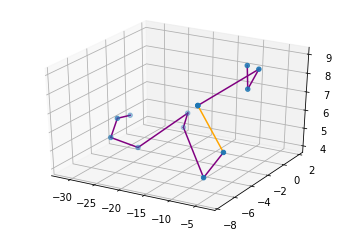

In [113]:
b_idx = 4 # batch_idx, recommended 4
s_idx = 3 # sample_idx, can change to plot different events

draw_3d_plot(summary['X'][b_idx][s_idx],
             summary['Ri'][b_idx][s_idx],
             summary['Ro'][b_idx][s_idx],
             summary['Edge_Labels'][b_idx][s_idx],
             test_labels[s_idx],
             test_True_Ri[s_idx],
             test_True_Ro[s_idx]
            )

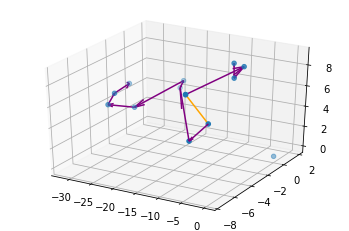

In [89]:
draw_3d_arrows(summary['X'][b_idx][s_idx],
             summary['Ri'][b_idx][s_idx],
             summary['Ro'][b_idx][s_idx],
             summary['Edge_Labels'][b_idx][s_idx],
             test_labels[s_idx],
             test_True_Ri[s_idx],
             test_True_Ro[s_idx]
            )

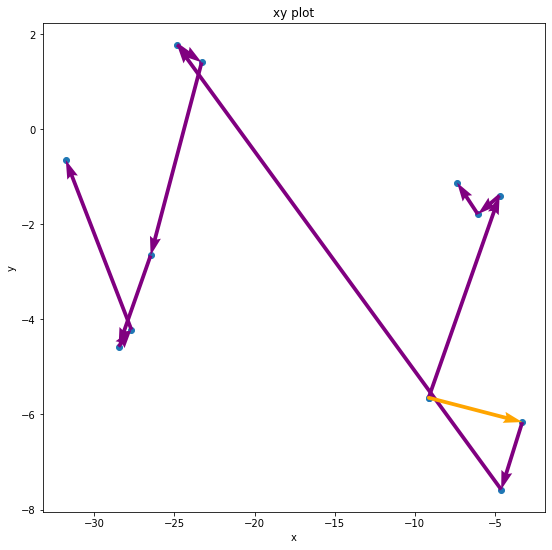

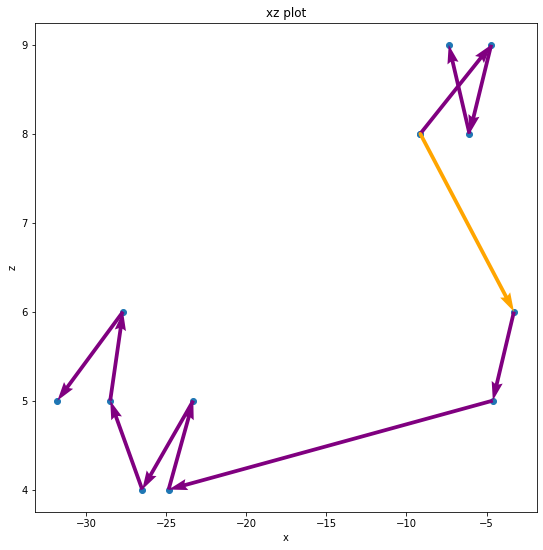

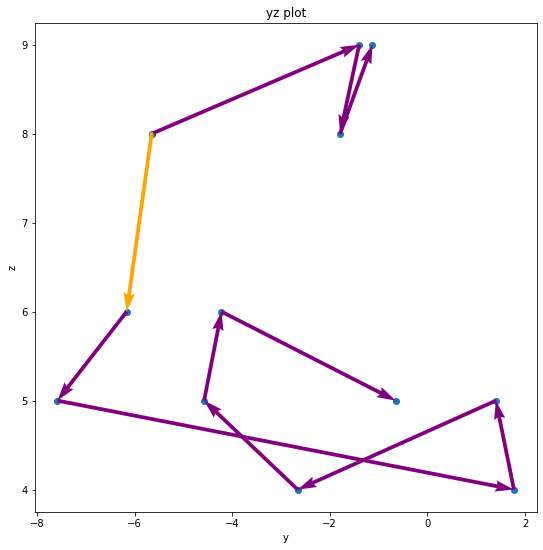

In [130]:
#XY
draw_2d_plot(np.array(summary['X'][b_idx][s_idx]),
             summary['Ri'][b_idx][s_idx],
             summary['Ro'][b_idx][s_idx],
             summary['Edge_Labels'][b_idx][s_idx],
             test_labels[s_idx],
             test_True_Ri[s_idx],
             test_True_Ro[s_idx],
             axis=(0, 1))

#XZ
draw_2d_plot(np.array(summary['X'][b_idx][s_idx]),
             summary['Ri'][b_idx][s_idx],
             summary['Ro'][b_idx][s_idx],
             summary['Edge_Labels'][b_idx][s_idx],
             test_labels[s_idx],
             test_True_Ri[s_idx],
             test_True_Ro[s_idx],
             axis=(0, 2))

#YZ
draw_2d_plot(np.array(summary['X'][b_idx][s_idx]),
             summary['Ri'][b_idx][s_idx],
             summary['Ro'][b_idx][s_idx],
             summary['Edge_Labels'][b_idx][s_idx],
             test_labels[s_idx],
             test_True_Ri[s_idx],
             test_True_Ro[s_idx],
             axis=(1, 2))

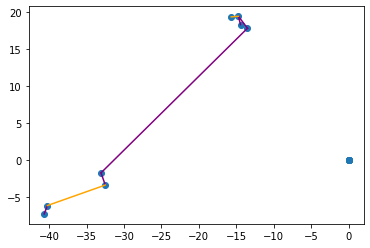

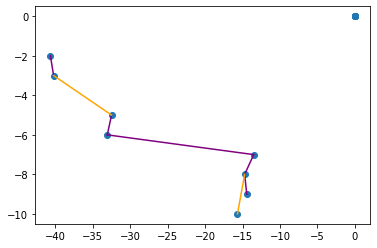

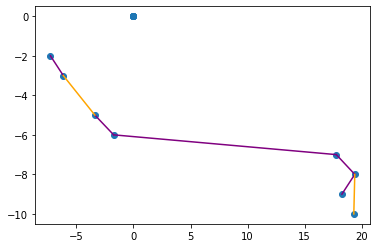

In [28]:
#XY
draw_2d_plot(summary['X'][b_idx][s_idx],
             summary['Ri'][b_idx][s_idx],
             summary['Ro'][b_idx][s_idx],
             summary['Edge_Labels'][b_idx][s_idx],
             test_labels[s_idx],
             test_True_Ri[s_idx],
             test_True_Ro[s_idx],
             axis=(0, 1))

#XZ
draw_2d_plot(summary['X'][b_idx][s_idx],
             summary['Ri'][b_idx][s_idx],
             summary['Ro'][b_idx][s_idx],
             summary['Edge_Labels'][b_idx][s_idx],
             test_labels[s_idx],
             test_True_Ri[s_idx],
             test_True_Ro[s_idx],
             axis=(0, 2))

#YZ
draw_2d_plot(summary['X'][b_idx][s_idx],
             summary['Ri'][b_idx][s_idx],
             summary['Ro'][b_idx][s_idx],
             summary['Edge_Labels'][b_idx][s_idx],
             test_labels[s_idx],
             test_True_Ri[s_idx],
             test_True_Ro[s_idx],
             axis=(1, 2))

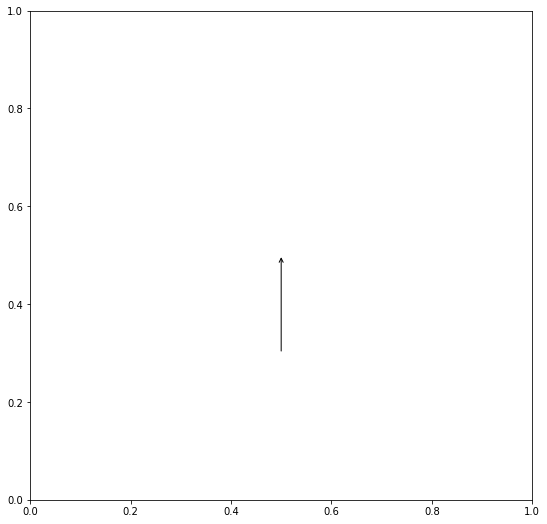

In [120]:
import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(6, 9))
# ax = plt.axes()
fig, ax = plt.subplots(figsize=(9, 9))
# plt.arrow(1, 1, 2, 2, head_width=0.05, head_length=0.1, fc='k', ec='k')
# ax.arrow()
plt.annotate("", xy=(0.5, 0.5), xytext=(0.5, 0.3), arrowprops=dict(arrowstyle="->"))
# plt.quiver(1, 1, 2, 2, scale=1)
plt.show()

In [121]:
OutputDirectory

'Results_20200430_165552'